## Set up environement

In [1]:
from os import path, makedirs
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [2]:
%load_ext autoreload
%autoreload 2
from parameters import *
from forward_model import *

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
makedirs(wd+"results/", exist_ok=True)
makedirs(wd+"RUN_SCRIPTS/", exist_ok=True)

## Perform some compute node -related tests

### Simple forward pass

In [5]:
script1_path = wd+"simple_forward_pass.py"

In [6]:
%%writetemplate {script1_path}
print("Loading libraries...")
from parameters import *
from forward_model import *
from matplotlib import pyplot as plt
import seaborn as sns
print("Done. Initializing BiasModelBORG for data_seed=0...")
BiasModel = BiasModelBORG("bias::BrokenPowerLaw")
print("Done. Performing forward pass for res=256...")
i = 3
parameters = np.array([2.5, 0.65, 1.5, 0.4])
count = BiasModel.get_count_field(i, parameters)
N = BiasModelBORG.get_N(BiasModel, i)
print("Done. Plotting slice_ref...")
slice_ref = count[:,:,N//2]
sns.heatmap(slice_ref)
plt.savefig(wd+"results/slice_ref.png")
print("Done. Saving slice_ref...")
np.save(wd+"results/slice_ref.npy", slice_ref)
print("Done.")

In [7]:
%%writetemplate {wd+"RUN_SCRIPTS/run1.py"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script1_path}"
exit 0

In [8]:
%%bash -s {wd+"RUN_SCRIPTS/run1.py"}
qsub $1

58486.imaster


One has to wait for the job launched above to finish before being able to run the following cell.

In [ ]:
slice_ref = np.load(wd+"results/slice_ref.npy")
# sns.heatmap(slice_ref) ; plt.show()

### Checks computation of errors

In [9]:
script2_path = wd+"checks_errors.py"

In [10]:
%%writetemplate {wd+"RUN_SCRIPTS/run2.py"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script2_path}"
exit 0

In [11]:
%%bash -s {wd+"RUN_SCRIPTS/run2.py"}
qsub $1

58487.imaster


## Optimisation for small parameters space

### Exploration

#### Checks varying the number of resolutions

In [12]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw")
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

24014242.99828543


In [13]:
# Should yield the same as the above cell
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_3"])
i = 0
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

24014242.99828543


In [14]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"])
i = 0
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*6)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

-283346.5714967363


#### Checks varying the number of mass bins considered

In [15]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

7688910.616374072


#### Checks varying the data seed

In [16]:
# Should yield the same as the above cell:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
BiasModel.load_data(0)
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

7688910.616374072


In [17]:
# Should be slightly different:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
BiasModel.load_data(1)
i = 3
parameters_list = np.array([[2.5, 0.65, 1.5, 0.4]]*2)
err = BiasModel.compute_fixed_res_error(i, parameters_list)
print(err)

7690777.016278771


#### Error on full dataset

In [18]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[2.5, 0.65, 1.5, 0.4]]*2]*2)
err = BiasModel.compute_error(parameters_list)
print(err)

-205578.0003294764


In [19]:
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_0", "res_1"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[1, 1, 1, 1]]*2]*2)
err = BiasModel.compute_error(parameters_list)
print(err)

368119.45590972394


In [20]:
BiasModel = BiasModelBORG("bias::Linear", reskeys=["res_0", "res_1", "res_2"],
                          fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1'])
parameters_list = np.array([[[1, 1]]*2]*3)
err = BiasModel.compute_error(parameters_list)
print(err)

182469.08089237404


#### Sequential computation of the total loss

##### Most complex case (all resolutions, all mass bins)

In [21]:
script3_path = wd+"try_full_loss_v1.py"

In [22]:
%%writetemplate {wd+"RUN_SCRIPTS/run3.py"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script3_path}"
exit 0

In [23]:
%%bash -s {wd+"RUN_SCRIPTS/run3.py"}
qsub $1

58488.imaster


Poisson:
```bash
####################
Computing error for bias model: bias::Linear
Error: 5.424980806430816
Time: 19.747969150543213
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 5.630357691003928
Time: 16.98229718208313
####################
Computing error for bias model: bias::SecondOrderBias
Error: 4.947548507437198
Time: 61.746253967285156
```

MSE:
```bash
####################
Computing error for bias model: bias::Linear
Error: 5.424980806430816
Time: 21.32629084587097

####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 5.630357691003928
Time: 31.602696895599365

####################
Computing error for bias model: bias::SecondOrderBias
Error: 4.947548507437198
Time: 78.03321027755737
```

##### Easy case (one resolution, two mass bins)

In [24]:
script4_path = wd+"try_full_loss_v2.py"

In [25]:
%%writetemplate {wd+"RUN_SCRIPTS/run4.py"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script4_path}"
exit 0

In [26]:
%%bash -s {wd+"RUN_SCRIPTS/run4.py"}
qsub $1

58489.imaster


Poisson:
```bash
####################
Computing error for bias model: bias::Linear
Error: -10303.13282692553
Time: 0.45497822761535645
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: -259920.0763539538
Time: 0.08563613891601562
####################
Computing error for bias model: bias::SecondOrderBias
Error: 9296010.143621296
Time: 0.6990132331848145
```

MSE:
```bash
####################
Computing error for bias model: bias::Linear
Error: 12.92336057566297
Time: 0.7955682277679443
####################
Computing error for bias model: bias::BrokenPowerLaw
Error: 12.617381975535864
Time: 0.1658039093017578
####################
Computing error for bias model: bias::SecondOrderBias
Error: 13.262693839300717
Time: 0.7903237342834473
```

### Perform optimisation in the simple case (dim 4 / dim 8 parameter space)

In [27]:
bias_model = "bias::BrokenPowerLaw"
# bias_model = "bias::SecondOrderBias"
# bias_model = "bias::Linear"

reskeys=["res_0"]
fields_to_load=['dm_overdensity', 'counts_bin_0']
# fields_to_load=['dm_overdensity', 'counts_bin_0', 'counts_bin_1']
nkeys = len(reskeys)
nfields = len(fields_to_load)-1
parameters_list_dict = {"bias::Linear": np.array([[[1, 1]]*nfields]*nkeys),
                        # "bias::BrokenPowerLaw": np.array([[[1,1,1,1]]*nfields]*nkeys),
                        "bias::BrokenPowerLaw": np.array([[[2.5, 0.65, 1.5, 0.4]]*nfields]*nkeys),
                        "bias::SecondOrderBias": np.array([[[1, 1, 1, 1]]*nfields]*nkeys)}

# TODO: define the correct physical bounds for the parameters:
bounds = {"bias::Linear": [(1., 500.), (0.01, 3.)]*nfields,
            "bias::BrokenPowerLaw": [(1., 500.), (0.01, 3.), (.01, 2.), (.01, 2.)]*nfields,
            "bias::SecondOrderBias": [(1., 500.), (0.01, 3.), (.01, 2.), (.01, 2.)]*nfields}

BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
parameters_list = parameters_list_dict[bias_model]
err = BiasModel.compute_error(parameters_list, loss="Poisson")
print(err)

-147916.9451378185


In [28]:
def error_function(parameters_list_flat):
    parameters_list = parameters_list_flat.reshape((nkeys, nfields, -1))
    return BiasModel.compute_error(parameters_list, loss="Poisson")

# The callback function is only used to print the parameters and the error at each iteration:
def callback_function(parameters_list_flat):
    parameters_list = parameters_list_flat.reshape((nkeys, nfields, -1))
    err = BiasModel.compute_error(parameters_list, loss="Poisson")
    print("Parameters: {}".format(parameters_list))
    print("Loss: {}".format(err))

initial_guess = parameters_list.flatten()

from scipy.optimize import minimize
res = minimize(error_function, initial_guess, method="L-BFGS-B", callback=callback_function,
               tol=1e-10,
               bounds=bounds[bias_model],
               options={'disp': True, 'eps':1e-5, 'finite_diff_rel_step': 1e-5})

print(res)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47917D+05    |proj g|=  4.97500D+02

At iterate    1    f= -3.45700D+05    |proj g|=  1.60550D+02
Parameters: [[[161.54969142   1.40129      1.65984894   0.27531783]]]
Loss: -345699.85969243484

At iterate    2    f= -6.05844D+05    |proj g|=  1.68475D+02
Parameters: [[[1.69474536e+02 1.00000000e-02 1.00000000e-02 2.00000000e+00]]]
Loss: -605844.1040727643

At iterate    3    f= -6.35692D+05    |proj g|=  5.61553D+01
Parameters: [[[168.61884705   0.21190377   0.41723395   2.        ]]]
Loss: -635692.0802930917

At iterate    4    f= -6.36566D+05    |proj g|=  7.34623D+01
Parameters: [[[168.57379375   0.27302286   0.5190901    2.        ]]]
Loss: -636565.8720409592

At iterate    5    f= -6.36723D+05    |proj g|=  3.88155D+01
Parameters: [[[168.61128152   0.27777285   0.49607696   1.98919391]]]
Lo

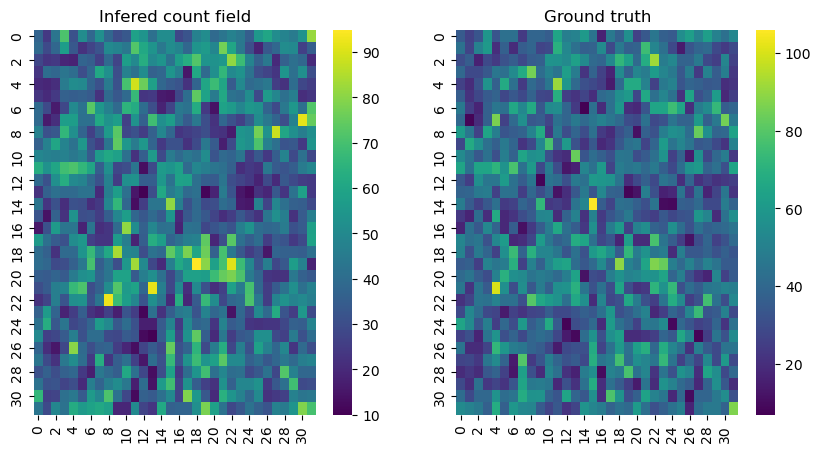

In [29]:
# Visualize the predictions with the optimized parameters:
BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
params = res.x.reshape((nkeys, nfields, -1))
BiasModel.plot_count_field(0, params[0][0], "counts_bin_0")

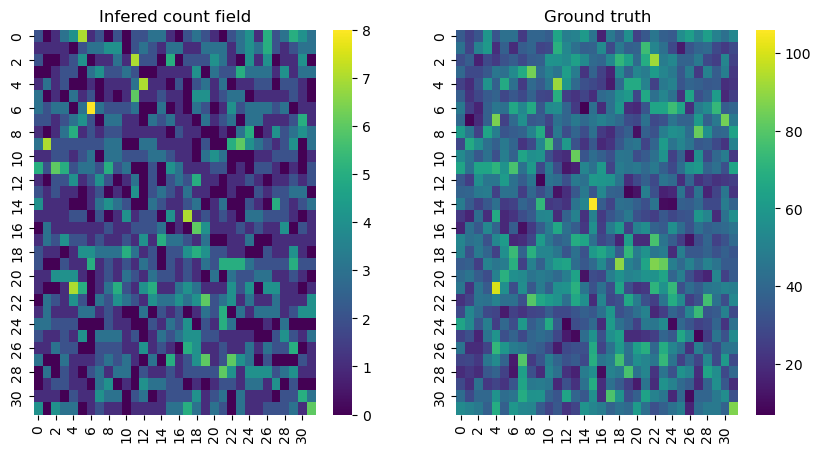

In [30]:
# Visualize the predictions with the initial parameters:
BiasModel = BiasModelBORG(bias_model, reskeys=reskeys, fields_to_load=fields_to_load)
BiasModel.plot_count_field(0, parameters_list[0][0], "counts_bin_0")

### Perform optimisation for a more complex case

In [31]:
script5_path = wd+"perform_opt.py"

In [32]:
bias_model = "bias::BrokenPowerLaw"
nkeys = 2
nfields = 2
identifier = "v0.1"

In [33]:
%%writetemplate {wd+"RUN_SCRIPTS/run5.py"}
{HEADER}
module load "intelpython/3-2023.0.0"
source activate borg
python "{script5_path}" --bias_model {bias_model} --id {identifier} --nkeys {nkeys} --nfields {nfields}
exit 0

In [34]:
%%bash -s {wd+"RUN_SCRIPTS/run5.py"}
qsub $1

58490.imaster


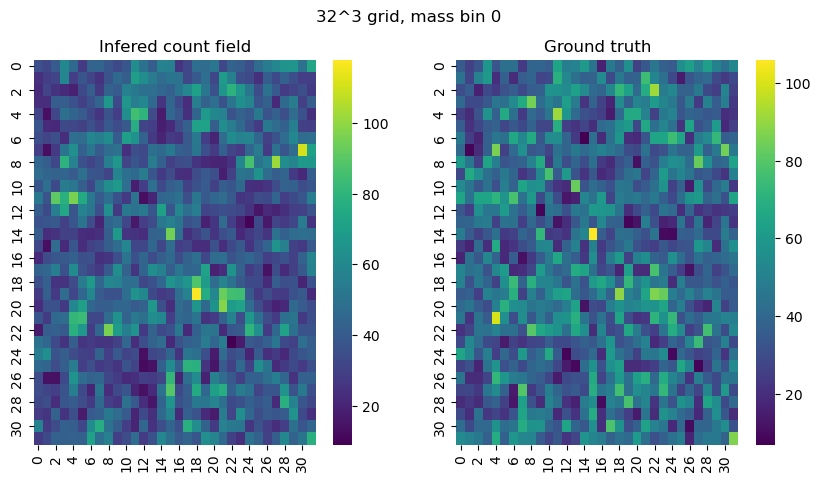

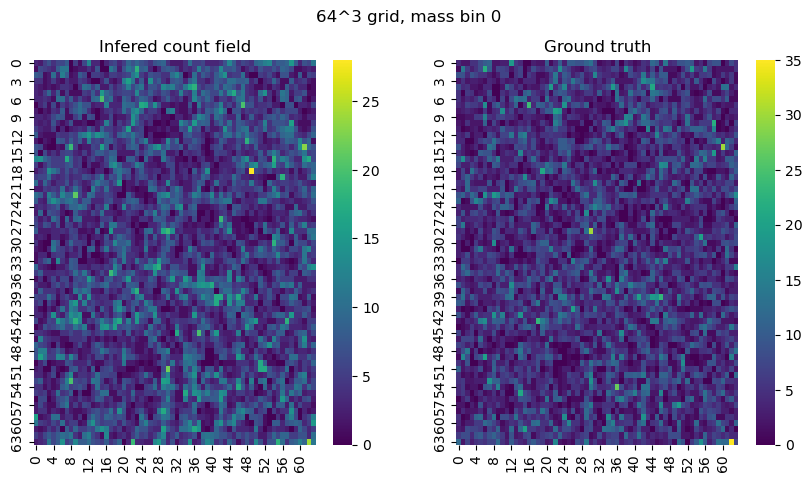

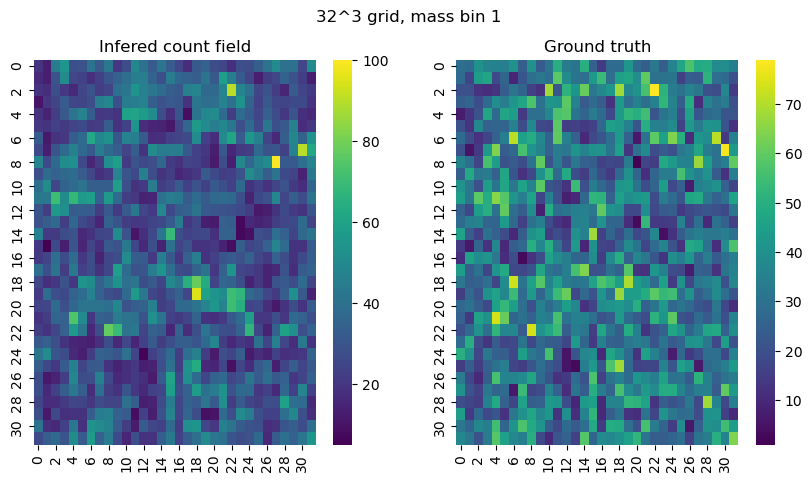

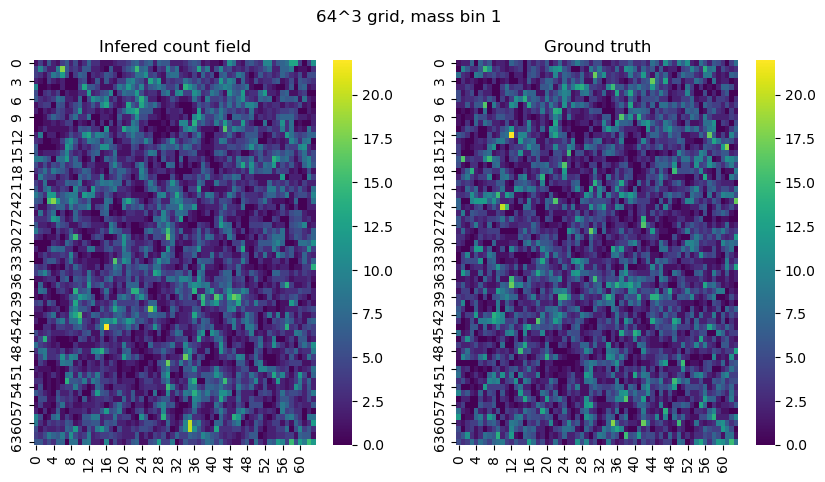

In [35]:
# Visualize the predictions with the optimized parameters:
params = np.load(wd+"results/"+str(nkeys)+'_'+str(nfields)+'_'+bias_model+"_opt_parameters_"+identifier+".npy")
# params = np.load(wd+"2_2_bias::BrokenPowerLaw_opt_parameters_v0.0.npy")
BiasModel = BiasModelBORG("bias::BrokenPowerLaw", reskeys=["res_{}".format(i) for i in range(nkeys)],
                          fields_to_load=['dm_overdensity'] + ["counts_bin_{}".format(i) for i in range(nfields)])
BiasModel.plot_count_field(0, params[0][0], "counts_bin_0", title="32^3 grid, mass bin 0")
BiasModel.plot_count_field(1, params[1][0], "counts_bin_0", title="64^3 grid, mass bin 0")
BiasModel.plot_count_field(0, params[0][1], "counts_bin_1", title="32^3 grid, mass bin 1")
BiasModel.plot_count_field(1, params[1][1], "counts_bin_1", title="64^3 grid, mass bin 1")